In [149]:
#### Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# Test of statistically
from statsmodels.tsa.vector_ar.vecm import coint_johansen
# used to do the Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller
# VAR model for multivariant forecasting
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [140]:
#### Functions

# Inverting the Differencing Transformation
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

# ADF Test to check for stationarity
def adf_test(ds):
    dftest = adfuller(ds, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")

In [141]:
# load the new file
ds = pd.read_csv('data_for_interview.csv', index_col=0)

In [142]:
ds.head()

,Datetime,WaterTemperature,DissolvedOxygen,device,site,weather_temperature,dewpoint,humidity,windspeed,winddirection
0,2020-06-15 09:00:00,22.810,98.200,device 1,site A,23.2,11.9,49,41.0,300
1,2020-06-15 11:00:00,22.910,98.460,device 1,site A,26.0,12.1,42,38.9,309
2,2020-06-15 12:00:00,22.910,NaN,device 1,site A,26.1,11.4,40,37.0,310
3,2020-06-15 14:00:00,23.365,101.585,device 1,site A,27.0,9.8,34,37.0,307
4,2020-06-15 16:00:00,23.470,NaN,device 1,site A,27.0,9.8,34,33.3,308


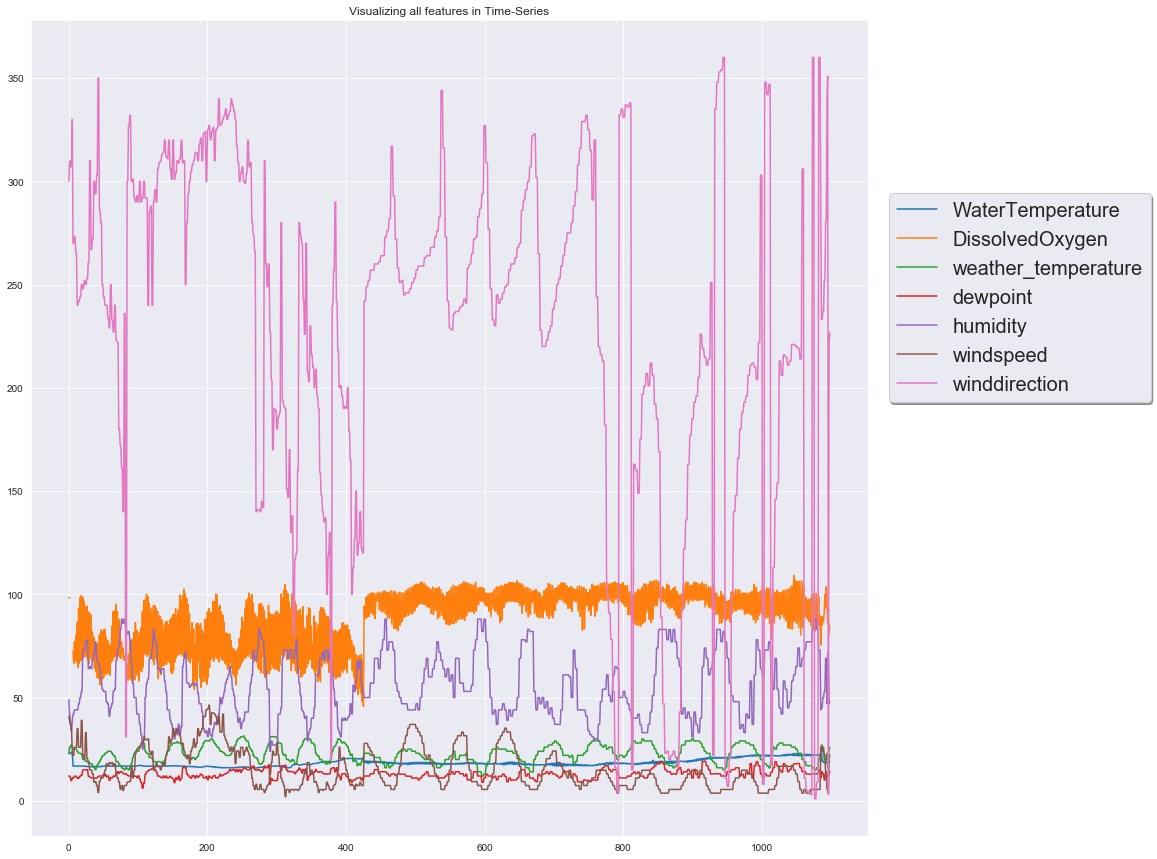

In [143]:
# Visualize the trends in data
sb.set_style('darkgrid')
ds.plot(kind = 'line', legend = 'reverse', title = 'Visualizing all features in Time-Series', figsize=(15, 15))
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8), prop={'size': 20})
plt.show()

In [144]:
# we observed that dates 23 and 24 are perfect for training our model (they have no missing data)
chosen_dates = ['2020-06-23', '2020-06-24']

In [145]:
# for each device we do the forecasting seperately
forecast_list = []
test_list = []
n_hours = 6 # number of hours that we are going to forecast

for i in range(1,6): # we have 5 devices (1 to 5)
    
    # make train and test datasets from the chosen dates
    ds_train = ds[ds['Datetime'].str.contains('|'.join(chosen_dates)) & ds['device'].str.contains(str(i))]
    ds_test = ds[ds['Datetime'].str.contains('2020-06-25') & ds['device'].str.contains(str(i))]

    
    # drop unnecessary columns
    ds_train = ds_train.drop(['Datetime','device','site','WaterTemperature'], axis=1) # 48 hours data as train
    ds_test = ds_test.drop(['Datetime','device','site','WaterTemperature'], axis=1)[:6] # we need the first 6 hours
    # WaterTemperature is dropped as it does not change significantly over time
    
    # Cointegration Test to look for statistically
    coint_result = coint_johansen(endog = ds_train, det_order = -1, k_ar_diff = 5).eig
    
    # Differencing all variables to get rid of Stationarity
    ds_differenced = ds_train.diff().dropna()
    
    # Running the ADF test to test for Stationarity
#     for i in ds_differenced.columns:
#         print("Column: ",i)
#         print('--------------------------------------')
#         adf_test(ds_differenced[i])
#         print('\n')
    
    # Now cols: 1, 2, 5 are non-stationary
    ds_differenced = ds_differenced.diff().dropna()
    
    # Fitting the VAR model to the 2nd Differenced Data
    model = VAR(ds_differenced)
    results = model.fit(maxlags = 5, ic = 'aic')
#     results.summary()

    # Forecasting for 6 steps ahead
    lag_order = results.k_ar
    predicted = results.forecast(ds_differenced.values[-lag_order:], n_hours)
    forecast = pd.DataFrame(predicted, index = ds_differenced.index[-n_hours:], columns = ds_differenced.columns)
    
    # Plotting the Forecasted values
#     p1 = results.plot_forecast(1)
#     p1.tight_layout()

    # Inverting the Differencing Transformation
    forecast_values = invert_transformation(ds_train, forecast, second_diff=True)

    # Add the forecast and test values to the list (just the objective column = DissolvedOxygen)
    forecast_list.append(forecast_values['DissolvedOxygen'].values)
    test_list.append(ds_test['DissolvedOxygen'].values)
    
    

C:\Users\amirz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\amirz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\amirz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\amirz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\amirz\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsup

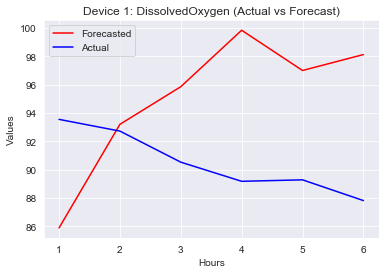

MSE:  61.093884329706434
RMSE:  7.816257693404589


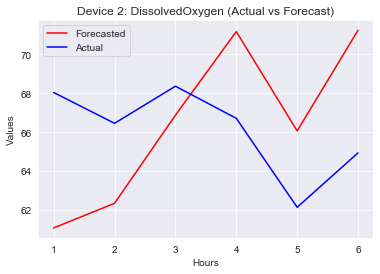

MSE:  23.8137812967417
RMSE:  4.879936607860977


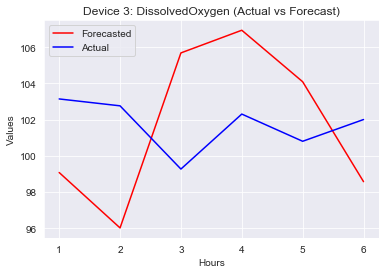

MSE:  24.495977429275452
RMSE:  4.949341110620226


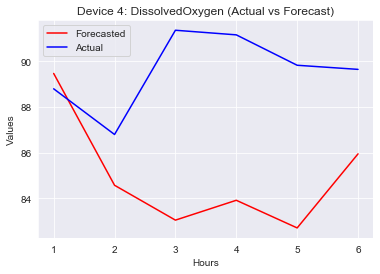

MSE:  31.838143666732197
RMSE:  5.6425298994982915


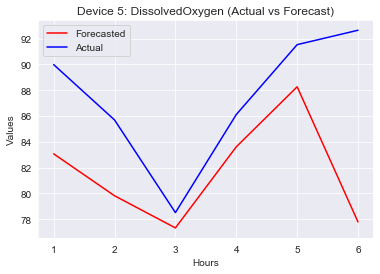

MSE:  53.505054230996706
RMSE:  7.314714911122422


In [159]:
# Plotting the Actual vs Forecasted for each device
for i in range(0,5):

    plt.plot(forecast_list[i], color='r', label='Forecasted')
    plt.plot(test_list[i], color='b', label='Actual')
    plt.title('Device '+ str(i+1) +': DissolvedOxygen (Actual vs Forecast)')
    plt.xlabel("Hours")
    plt.ylabel("Values")
    plt.xticks(range(0,6), range(1,7))
    plt.legend(loc="upper left")
    plt.show()
    
    # MSE
    
    mse = mean_squared_error(test_list[i], forecast_list[i])
    rmse = mse**(1/2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)